---
title: FID - Apodization
---

In [1]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 1. Use retina for crisp, PDF-like text that never disappears in HTML
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

# 2. Set a high baseline DPI
plt.rcParams["figure.dpi"] = 150

Apodization, or time-domain filtering, is a processing step applied prior to the Fourier transformation to enhance the Signal-to-Noise Ratio (SNR) and/or the spectral resolution of MR spectra.

During apodization, the time-domain Free Induction Decay (FID) signal, $f(t)$, is multiplied by a filter function, $f_{filter}(t)$.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Ensure the accessor is registered
import xmris

## 1. Generating Synthetic Data

Let's generate a synthetic FID consisting of a single decaying resonance with added Gaussian noise. We pack this into an `xarray.DataArray` to preserve physical coordinates and metadata.

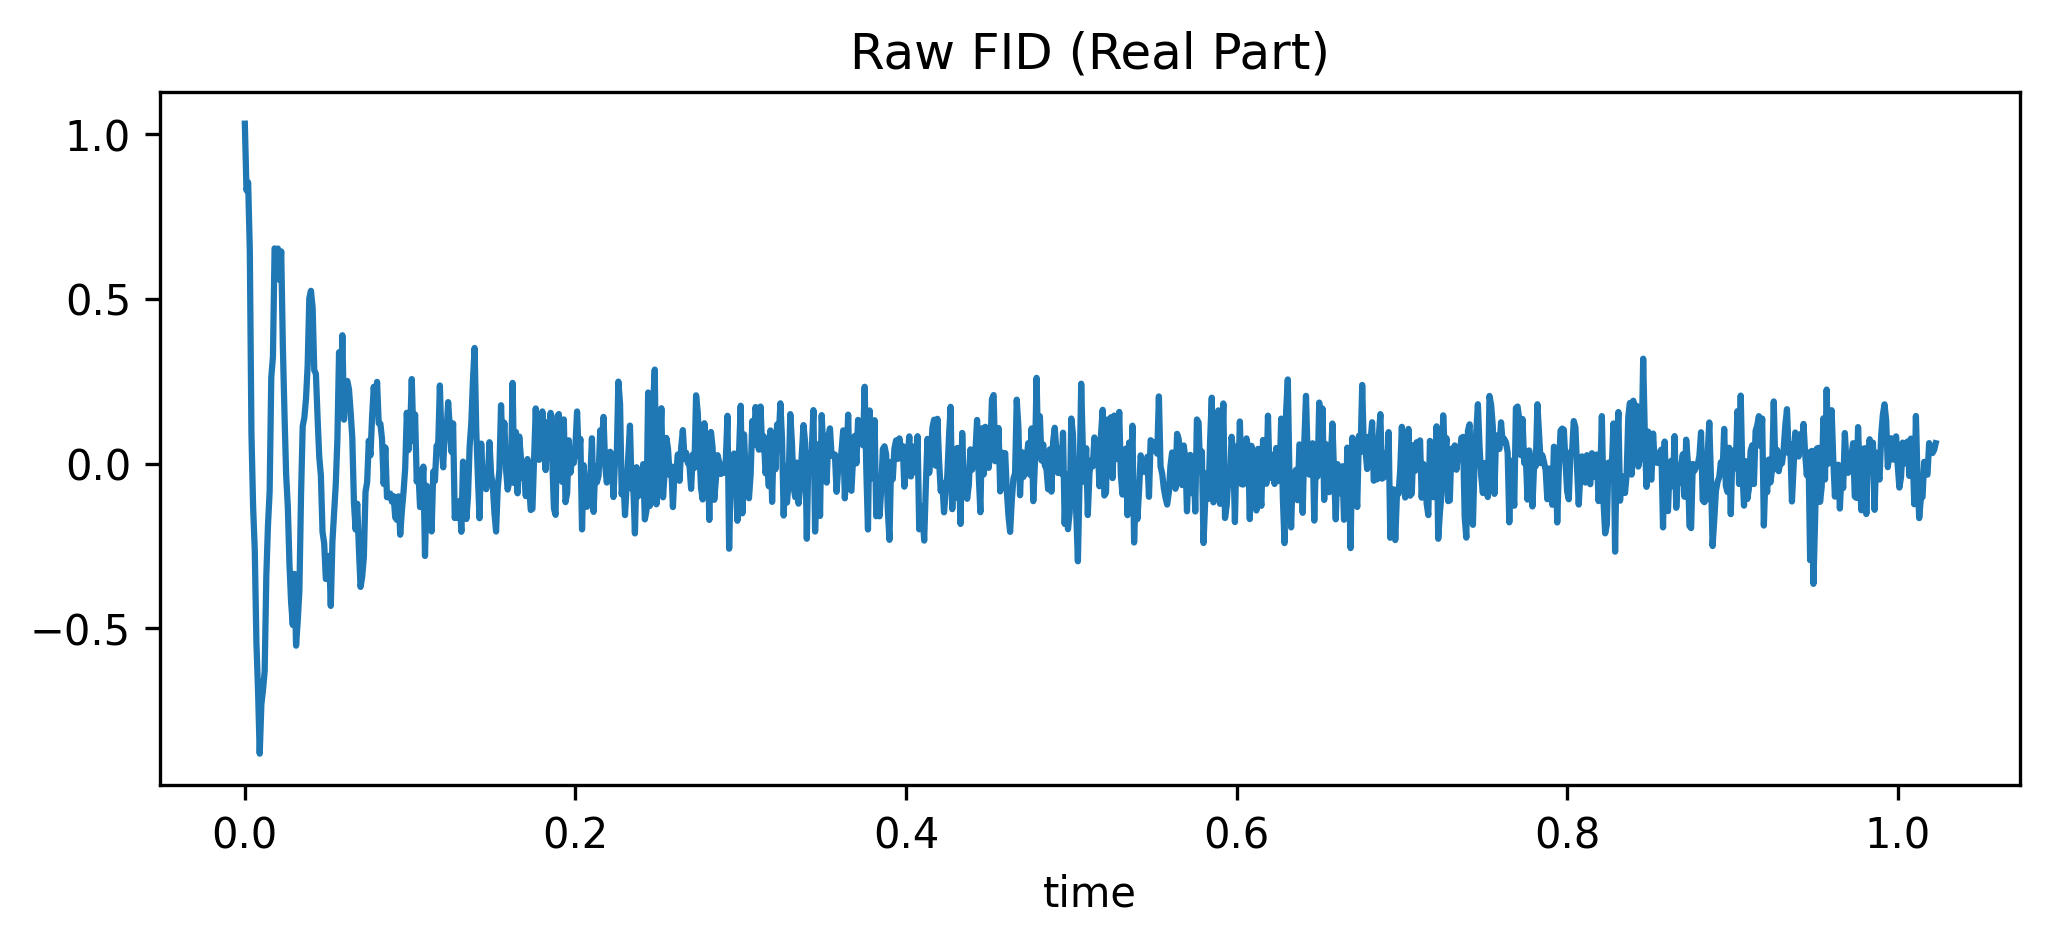

In [3]:
# Acquisition parameters
dwell_time = 0.001  # 1 ms
n_points = 1024
t = np.arange(n_points) * dwell_time

# Synthetic FID: 50 Hz resonance, T2* = 0.05s, plus complex noise
rng = np.random.default_rng(42)
clean_fid = np.exp(-t / 0.05) * np.exp(1j * 2 * np.pi * 50 * t)
noise = rng.normal(scale=0.1, size=n_points) + 1j * rng.normal(scale=0.1, size=n_points)
raw_fid = clean_fid + noise

# Xarray construction
da_fid = xr.DataArray(
    raw_fid, dims=["time"], coords={"time": t}, attrs={"sequence": "PRESS", "B0": 3.0}
)

da_fid.real.plot(figsize=(8, 3))
plt.title("Raw FID (Real Part)")
plt.show()

By default, taking the Fourier transform of this raw signal yields a noisy spectrum.

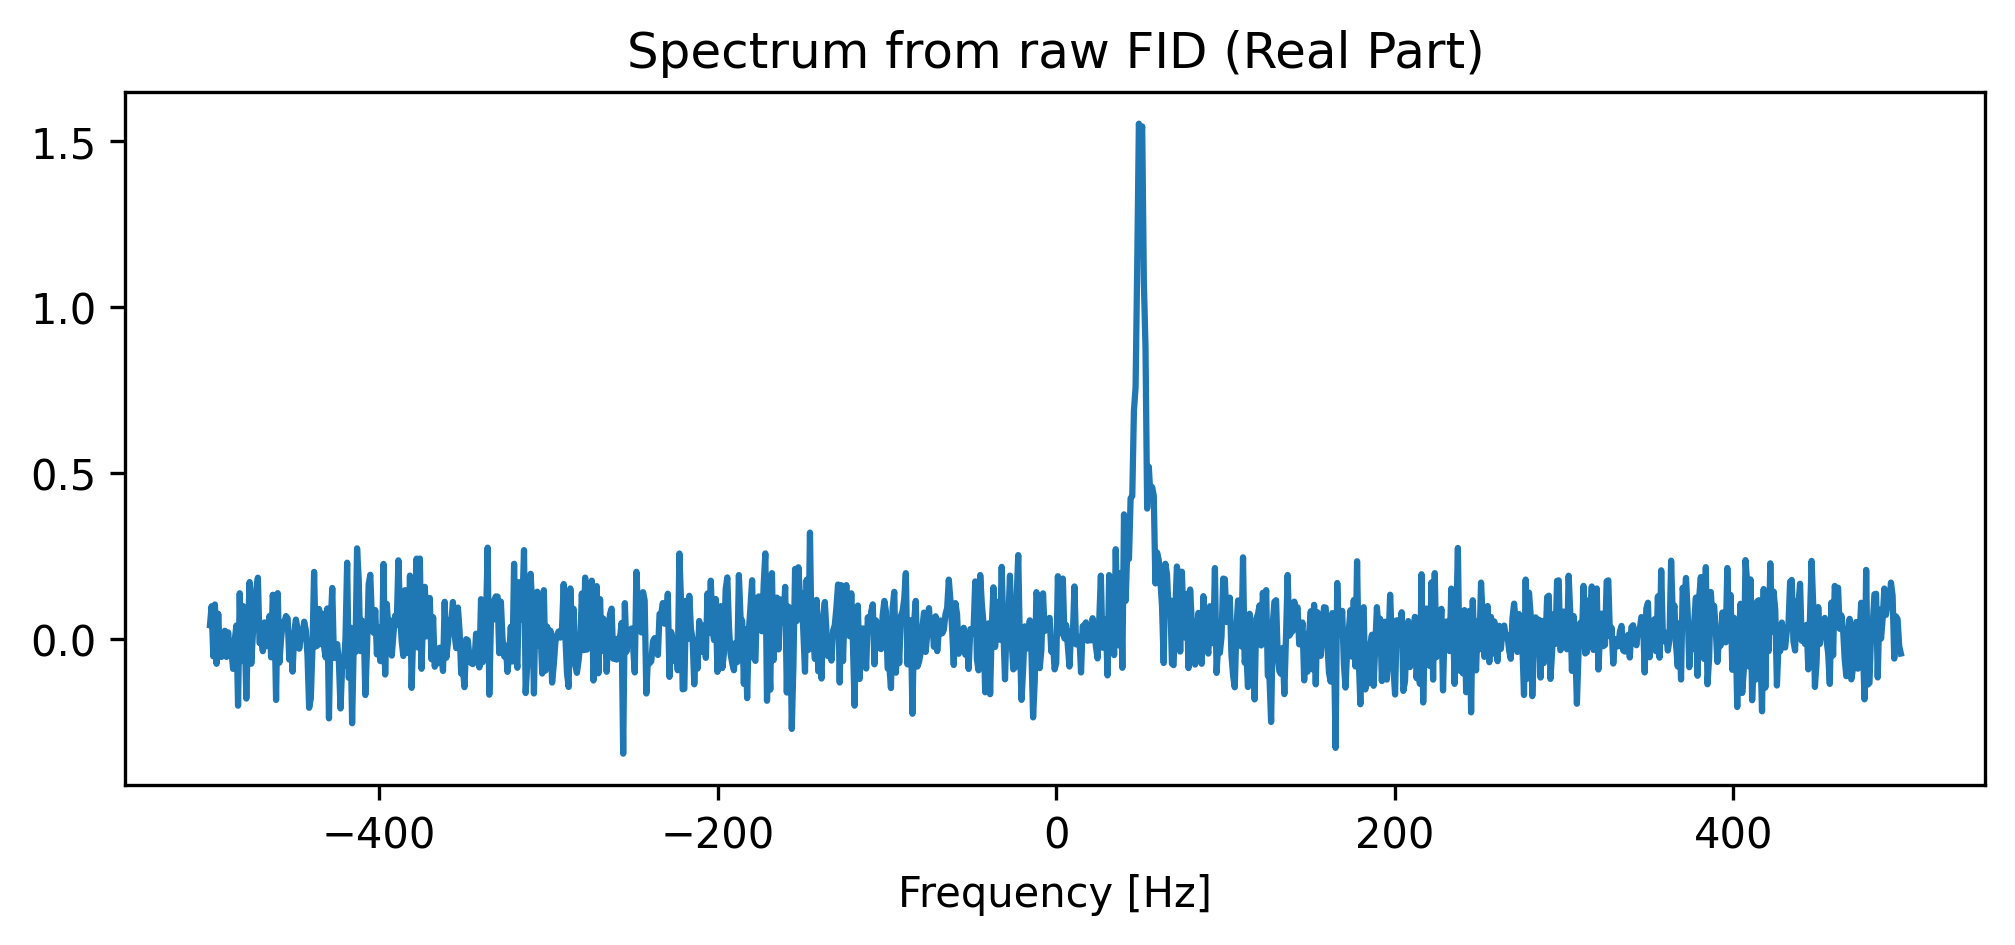

In [4]:
da_fid.xmr.to_spectrum().real.plot(figsize=(8, 3))
plt.title("Spectrum from raw FID (Real Part)")
plt.show()

---

## 2. Exponential Apodization (Line Broadening)

A common filter function is the decreasing mono-exponential weighting: $f_{filter}(t) = e^{-t/T_L}$.

This filter improves the SNR of the spectrum because data points at the end of the FID, which primarily contain noise, are heavily attenuated. However, this causes the FID to decay faster than its natural $T_2^*$, leading to broader resonance lines. Because of this, time-domain apodization with a decreasing exponential is commonly referred to as "line broadening".

In `xmris`, we parameterize this using the line broadening factor in Hz (`lb`), where $T_L = \frac{1}{\pi \cdot \text{lb}}$.

:::{dropdown} Why is `lb` in Hz?
In NMR and MRS, the natural decay of the Free Induction Decay (FID) is governed by the apparent transverse relaxation time, $T_2^*$. The Fourier Transform of an exponentially decaying signal $e^{-t/T_2^*}$ yields a Lorentzian peak shape in the frequency domain. 

The Full Width at Half Maximum (FWHM) of this Lorentzian peak is directly tied to the decay rate:
$$ \text{FWHM} = \frac{1}{\pi T_2^*} $$
Because $T_2^*$ is measured in seconds, this FWHM is inherently measured in Hertz (Hz).



When we multiply the FID by an exponential apodization filter $e^{-t/T_L}$, we are artificially accelerating the signal decay. The effective decay time becomes:
$$ \frac{1}{T_{2,eff}^*} = \frac{1}{T_2^*} + \frac{1}{T_L} $$

Multiplication in the time domain equates to convolution in the frequency domain. The convolution of two Lorentzians yields a new Lorentzian whose width is simply the sum of the two original widths:
$$ \text{FWHM}_{eff} = \text{FWHM}_{natural} + \text{lb} $$

Therefore, the `lb` parameter is conveniently defined in **Hz** because it represents the exact, quantifiable amount of extra width you are adding to the resonance peaks in your final spectrum!
:::

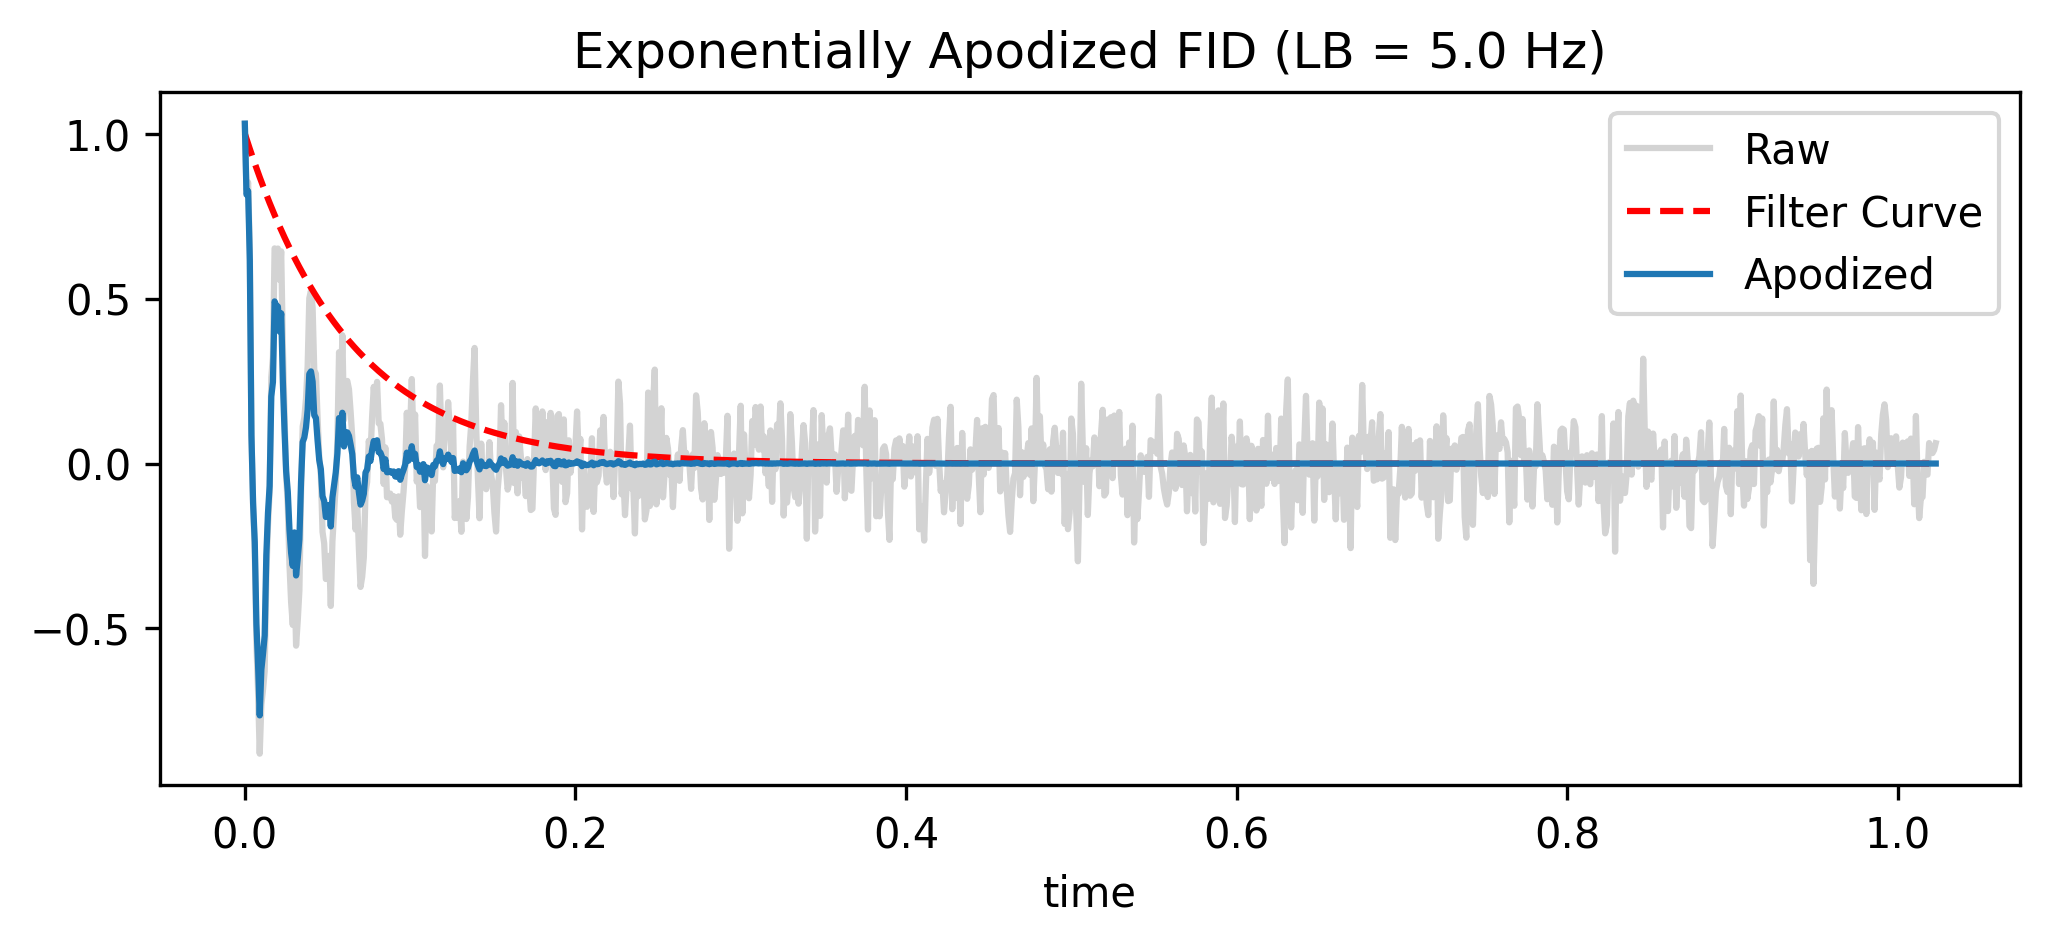

In [21]:
# Apply 5 Hz of line broadening
lb = 5.0
da_exp = da_fid.xmr.apodize_exp(dim="time", lb=lb)

# Calculate the filter curve for visualization
t_coords = da_fid.coords["time"].values
filter_exp = np.exp(-np.pi * lb * t_coords)

fig, ax = plt.subplots(figsize=(8, 3))

# plot the original spectrum as gray background
da_fid.real.plot(ax=ax, color="lightgray", label="Raw")
# overlay the filter curve
ax.plot(t_coords, filter_exp, color="red", linestyle="--", label="Filter Curve")
# plot the apodized FID
da_exp.real.plot(ax=ax, label="Apodized")


plt.title(f"Exponentially Apodized FID (LB = {lb} Hz)")
plt.legend()
plt.show()

:::{dropdown} Under the Hood: No Magic Strings
As a user, you can pass simple strings like `"time"` and `"frequency"` to `xmris` functions. However, internally, the package never uses raw strings. It maps your input to a strict global vocabulary (`xmris.core.config.DIMS` and `COORDS`).

This architecture allows `xmris` to intercept your request and automatically inject physical metadata (like setting the new coordinate units to `Hz` or `s`) without you ever having to ask for it!

For more info see [xmris Architecture: Why We Built It This Way](https://www.google.com/search?q=./architecture.ipynb)
:::

Here is the resulting, smoothed spectrum:

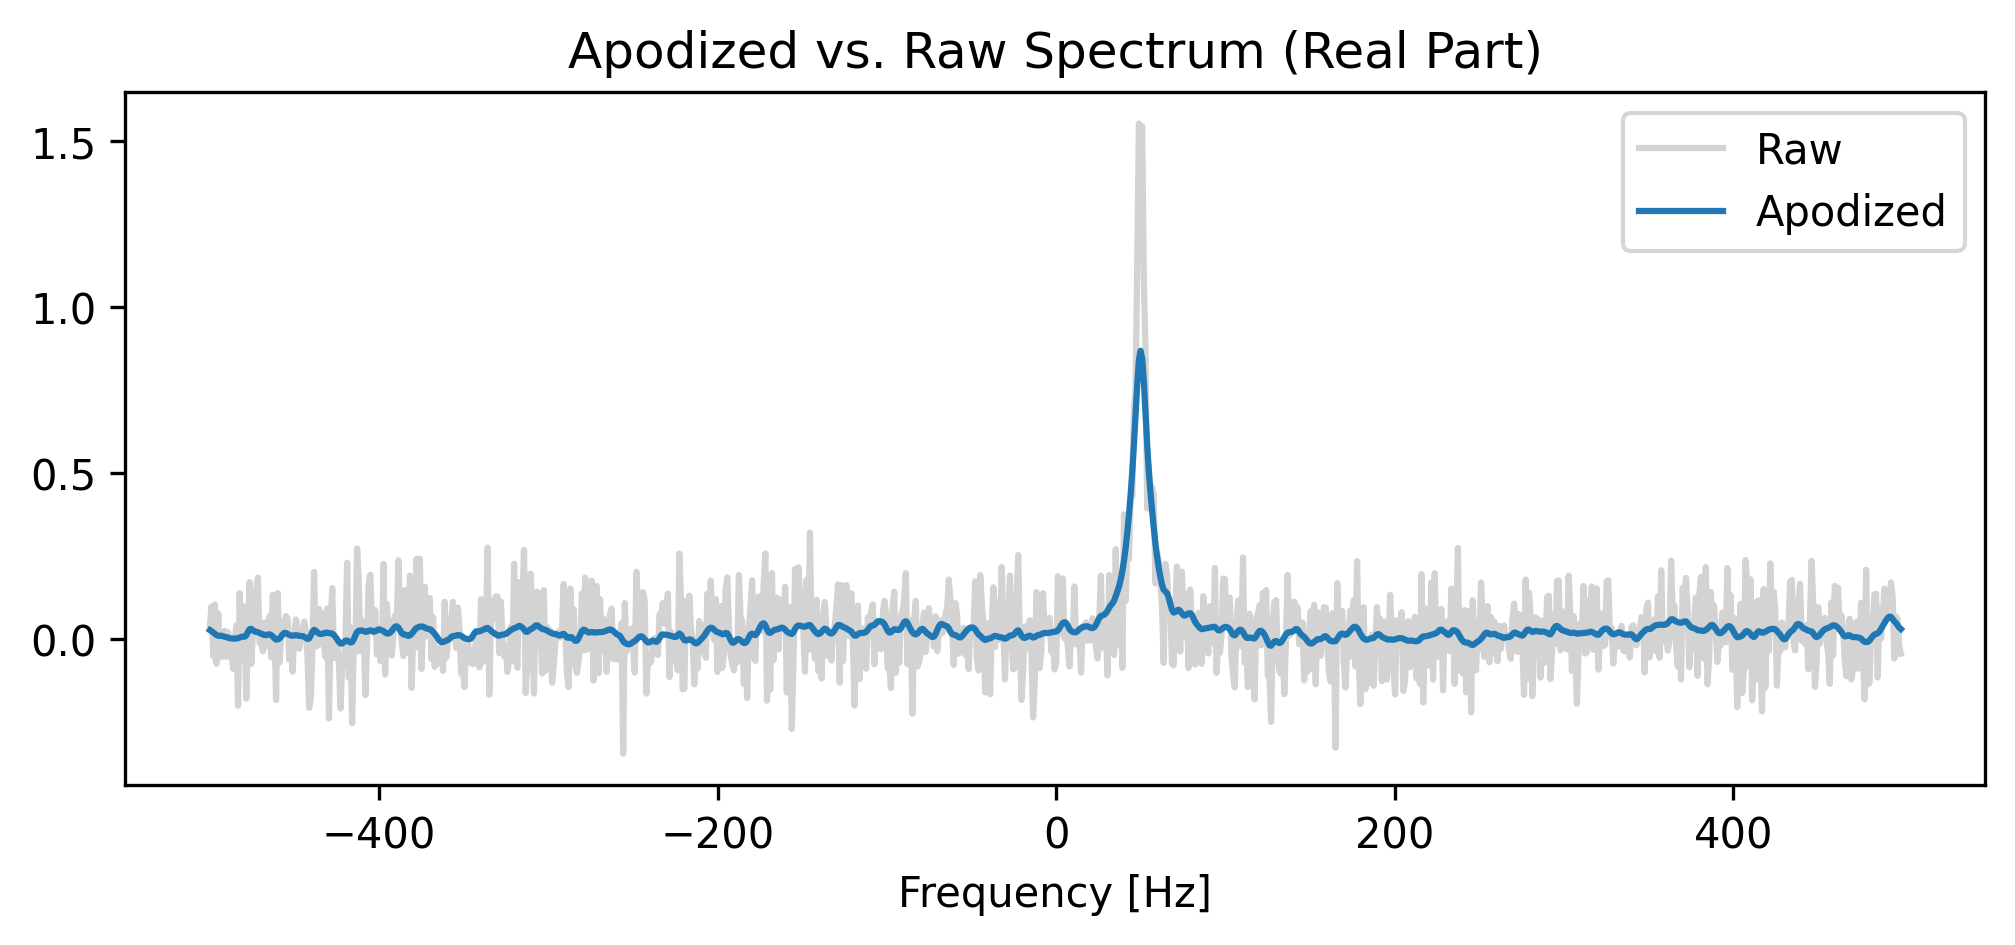

In [6]:
fig, ax = plt.subplots(figsize=(8, 3))

da_fid.xmr.to_spectrum().real.plot(ax=ax, color="lightgray", label="Raw")
da_exp.xmr.to_spectrum().real.plot(ax=ax, label="Apodized")
plt.title("Apodized vs. Raw Spectrum (Real Part)")
plt.legend()
plt.show()

In [7]:
# STRICT TESTS: Exponential Apodization
_lb = 5.0
_t = da_fid.coords["time"].values
_expected_weight = np.exp(-np.pi * _lb * _t)
_expected_vals = da_fid.values * _expected_weight

# Prove math
np.testing.assert_allclose(
    da_exp.values, _expected_vals, err_msg="Exponential math failed."
)

# Prove coordinate and dimension preservation
assert da_exp.dims == da_fid.dims, "Dimensions altered."
np.testing.assert_array_equal(
    da_exp.coords["time"].values,
    da_fid.coords["time"].values,
    err_msg="Coords altered.",
)

# Prove lineage stamping and attribute preservation
for k, v in da_fid.attrs.items():
    assert da_exp.attrs[k] == v, f"Original attribute '{k}' was dropped."
assert da_exp.attrs.get("apodization") == "exponential", "Lineage failed: missing apodization type."
assert da_exp.attrs.get("apodization_lb") == _lb, "Lineage failed: missing lb factor."

---

## 3. Lorentzian-to-Gaussian Transformation

The Lorentzian-to-Gaussian filter converts a standard Lorentzian line shape into a Gaussian line shape, which decays to the baseline in a narrower frequency range. A standard Lorentzian shape produces longer "tails", which is a disadvantage when trying to accurately integrate overlapping resonance lines.

The time-domain FID is multiplied by the function $f_{filter}(t) = e^{+t/T_L}e^{-t^2/T_G^2}$.

The principle is to cancel the Lorentzian part of the FID (using a positive exponential parameterized by $T_L$) while concurrently increasing the Gaussian character of the FID (using the squared exponential parameterized by $T_G$). In `xmris`, we parameterize these using Lorentzian line broadening to cancel (`lb`) and Gaussian line broadening to apply (`gb`).

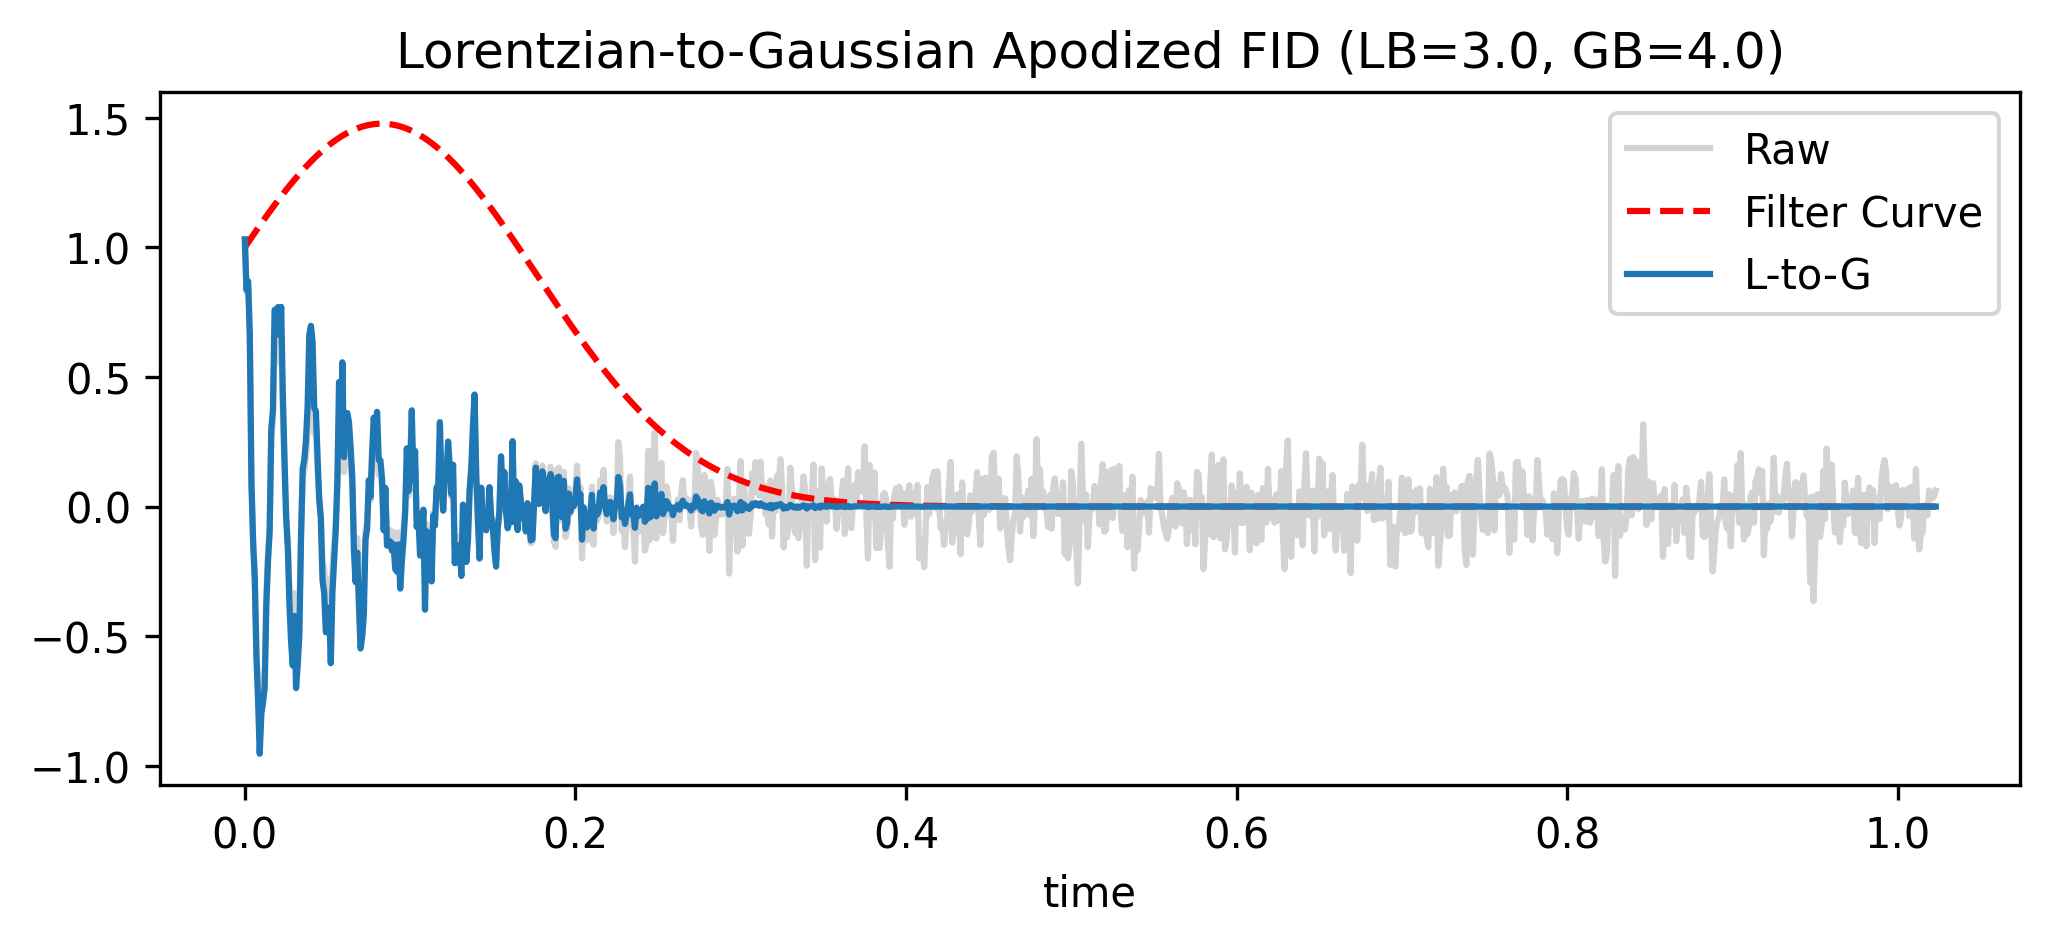

In [23]:
# Cancel 3 Hz of Lorentzian broadening and apply 4 Hz of Gaussian broadening
lb = 3.0
gb = 4.0
da_lg = da_fid.xmr.apodize_lg(dim="time", lb=lb, gb=gb)

# Calculate the filter curve for visualization
t_coords = da_fid.coords["time"].values
weight_lorentzian = np.exp(np.pi * lb * t_coords)
t_g = (2 * np.sqrt(np.log(2))) / (np.pi * gb)
weight_gaussian = np.exp(-(t_coords**2) / (t_g**2))
filter_lg = weight_lorentzian * weight_gaussian

fig, ax = plt.subplots(figsize=(8, 3))
# plot the original spectrum as gray background
da_fid.real.plot(ax=ax, color="lightgray", label="Raw")
# overlay the filter curve
ax.plot(t_coords, filter_lg, color="red", linestyle="--", label="Filter Curve")
# plot the apodized FID
da_lg.real.plot(ax=ax, label="L-to-G")

plt.title(f"Lorentzian-to-Gaussian Apodized FID (LB={lb}, GB={gb})")
plt.legend()
plt.show()

Resulting in a spectrum with fundamentally different peak shapes:

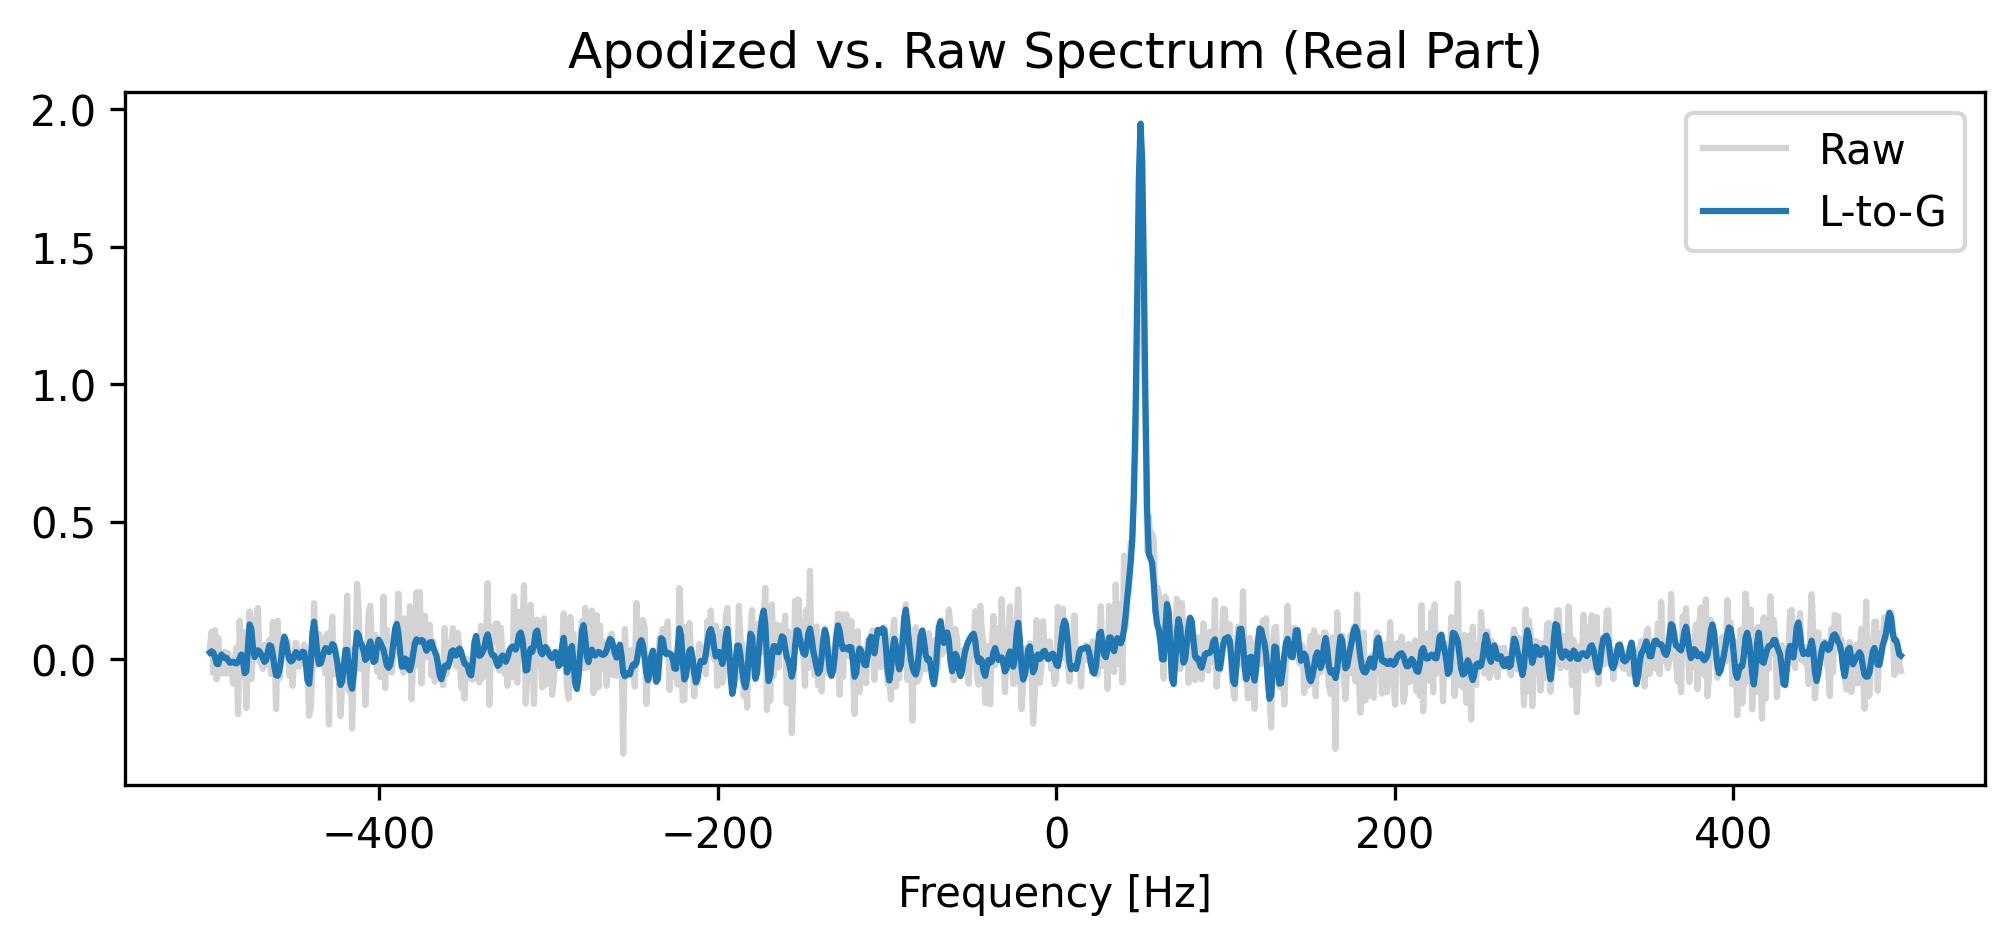

In [9]:
fig, ax = plt.subplots(figsize=(8, 3))

da_fid.xmr.to_spectrum().real.plot(ax=ax, color="lightgray", label="Raw")
da_lg.xmr.to_spectrum().real.plot(ax=ax, label="L-to-G")
plt.title("Apodized vs. Raw Spectrum (Real Part)")
plt.legend()
plt.show()

In [10]:
# STRICT TESTS: Lorentzian-to-Gaussian Apodization
_lb_lg = 3.0
_gb_lg = 4.0

_weight_lorentzian = np.exp(np.pi * _lb_lg * _t)
_t_g = (2 * np.sqrt(np.log(2))) / (np.pi * _gb_lg)
_weight_gaussian = np.exp(-(_t**2) / (_t_g**2))

_expected_lg_vals = da_fid.values * (_weight_lorentzian * _weight_gaussian)

# Prove math
np.testing.assert_allclose(da_lg.values, _expected_lg_vals, err_msg="L-to-G math failed.")

# Prove coordinate and dimension preservation
assert da_lg.dims == da_fid.dims, "Dimensions altered."
np.testing.assert_array_equal(
    da_lg.coords["time"].values, da_fid.coords["time"].values, err_msg="Coords altered."
)

# Prove lineage stamping and attribute preservation
for k, v in da_fid.attrs.items():
    assert da_lg.attrs[k] == v, f"Original attribute '{k}' was dropped."
assert da_lg.attrs.get("apodization") == "lorentzian-to-gaussian", "Lineage failed: missing apodization type."
assert da_lg.attrs.get("apodization_lb") == _lb_lg, "Lineage failed: missing lb factor."
assert da_lg.attrs.get("apodization_gb") == _gb_lg, "Lineage failed: missing gb factor."